# Kernel Derivatives


**Resources**

* [Differentating Gaussian Processes](http://mlg.eng.cam.ac.uk/mchutchon/DifferentiatingGPs.pdf) - Andrew McHutchen

## Paper Idea

**Linear Operators and Stochastic Partial Differential Equations in GPR** - Simo Särkkä - [PDF](https://users.aalto.fi/~ssarkka/pub/spde.pdf)

> Expresses derivatives of GPs as operators

[**Demo Colab Notebook**](https://colab.research.google.com/drive/1pbb0qlypJCqPTN_cu2GEkkKLNXCYO9F2)

He looks at ths special case where we have a GP with a mean function zero and a covariance matrix $K$ defined as:
$$
\mathbb{E}[f(\mathbf{x})f^\top(\mathbf{x'})] = K_{ff}(\mathbf{x,x'})
$$
So in GP terminology:
$$
f(\mathbf(x)) \sim \mathcal{GP}(\mathbf{0}, K_{ff}(\mathbf{x,x'}))
$$
We use the rulse for linear transformations of GPs to obtain the different transformations of the kernel matrix. 

Let's define the notation for the derivative of a kernel matrix. Let $g(\cdot)$ be the derivative operator on a function $f(\cdot)$. So:
$$
g(\mathbf{x}) = \mathcal{L}_x f(\mathbf{x})
$$

So now, we want to define the cross operators between the derivative $g(\cdot)$ and the function $f(\cdot)$. 

**Example**: He draws a distinction between the two operators with an example of how this works in practice. So let's take the linear operator $\mathcal{L}_{x}=(1, \frac{\partial}{\partial x})$. This operator:

* acts on a scalar GP $f(x)$
* a scalar input $x$ 
* a covariance function $k_{ff}(x,x')$ 
* outputs a scalar value $y$



We can get the following transformations:
$$
\begin{aligned}
K_{gf}(\mathbf{x,x'})
&= \mathcal{L}_x f(\mathbf{x}) f(\mathbf{x}) = \mathcal{L}_xK_{ff}(\mathbf{x,x'}) \\
K_{fg}(\mathbf{x,x'})
&= f(\mathbf{x}) f(\mathbf{x'}) \mathcal{L}_{x'} = K_{ff}(\mathbf{x,x'})\mathcal{L}_{x'} \\
K_{gg}(\mathbf{x,x'})
&= \mathcal{L}_x f(\mathbf{x}) f(\mathbf{x'}) \mathcal{L}_{x'}
= \mathcal{L}_xK_{ff}(\mathbf{x,x'})\mathcal{L}_{x'}^\top \\
\end{aligned}
$$

In [1]:
#@title Packages
import functools

import jax
import jax.numpy as jnp
import numpy as onp
from sklearn.metrics.pairwise import rbf_kernel as rbf_sklearn
# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

In [2]:
#@title Plot Functions

def plot_kernel_mat(K):
    # plot
    plt.figure()
    plt.imshow(K, cmap='Reds')
    plt.title(r'$K_{ff}$, (rbf)', fontsize=20, weight='bold')
    plt.tight_layout()
    plt.show()

In [3]:
#@title Data

def get_1d_data(N=30, sigma_inputs=0.15, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X = jnp.linspace(-10, 10, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X))
    Y += sigma_obs * onp.random.randn(N)
    X += sigma_inputs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X_test = jnp.linspace(-11, 11, N_test) 
    X_test += sigma_inputs * onp.random.randn(N_test)

    X = X[:, None]
    X_test = X[:, None]

    assert X.shape == (N,1)
    assert Y.shape == (N,)

    return X, Y, X_test

def get_2d_data(N=30, sigma_obs=0.15, N_test=400):
    onp.random.seed(0)
    X1 = jnp.linspace(-10, 10, N)
    X2 = jnp.linspace(-5, 2, N)
    # Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y = jnp.sin(1.0 * jnp.pi / 1.6 * jnp.cos(5 + .5 * X1)) + jnp.exp(X2)
    Y += sigma_obs * onp.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)



    X1_test = jnp.linspace(-11, 11, N_test)
    X2_test = jnp.linspace(-6, 4, N_test) 

    X = jnp.vstack((X1,X2)).T
    X_test = jnp.vstack((X1_test,X2_test)).T

    assert X.shape == (N,2)
    assert Y.shape == (N,)

    return X, Y, X_test

# Get Data
X, Y, X_test = get_1d_data(100, sigma_inputs=0.0, sigma_obs=0.1, N_test=100)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Kernel Function

In [4]:
#@title Kernel Functions

# Squared Euclidean Distance Formula
@jax.jit
def sqeuclidean_distance(x, y):
    return jnp.sum((x-y)**2)

# RBF Kernel
@jax.jit
def rbf_kernel(params, x, y):
    return jnp.exp( - params['gamma'] * sqeuclidean_distance(x, y))
    
# Covariance Matrix
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

#### RBF Kernel

In [39]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X[:1, :]
test_Y = X[:1, :]

rbf_x_sk = rbf_sklearn(
    onp.array(test_X.reshape(1, -1)), 
    onp.array(test_Y.reshape(1, -1)), 
    gamma=1.0
)
print(rbf_x_sk.shape, test_X.shape)

params = {'gamma': 1.0, 'var_f': 1.0}
gamma=1.0
rbf_k_ = functools.partial(rbf_kernel, params)
rbf_x = rbf_k_(
    test_X.squeeze(), 
    test_Y.squeeze()
)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), rbf_x_sk)

(1, 1) (1, 2)


### Kernel Matrix

We defined all of our functions above with only dimensions in mind, not the number of samples or the batch size. So we need to account for that. So if we wanted to calculate the kernel matrix, we would have to loop through all of the samples and calculate the products individually, which would take a long time; especially for large amounts of data. 

> Avoid Loops at all cost in python...

Fortunately, Jax has this incredible function `vmap` which handles batching automatically at apparently, no extra cost. So we can write our functions to account for vectors without having to care about the batch size and then use the `vmap` function to essentially "vectorize" our functions. It essentially allows us to take a product between a matrix and a sample or two vectors of multiple samples. Let's go through an example of how we can construct our kernel matrix.

1. We need to map all points with one vector to another.

We're going to take a single sample from $X'$ and take the rbf kernel between it and all of $X$. So:

$$\text{vmap}_f(\mathbf{X}, \mathbf{x})$$

where $X\in \mathbb{R}^{N \times D}$ is a matrix and $\mathbf{x} \in \mathbb{R}^{D}$ is a vector.

In [40]:
# Gram Matrix
def gram(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

In [41]:
# map function 1
mapx1 = jax.vmap(lambda x, y: rbf_kernel(params, x, y), in_axes=(0, None), out_axes=0)

# test the mapping
x1_mapped = mapx1(X, X[0, :])

# Check output shapes, # of dimensions
assert x1_mapped.shape[0] == X.shape[0]   
assert jnp.ndim(x1_mapped) == 1   

This that's good: we have an array of size $N$. So we've effectively mapped all points from one array to the other. 

So now we can do another vector mapping which allows us to take all samples of $X'$ and map them against all samples of $X$. So it'll be a `vmap` of a `vmap`. Then we'll get the $N\times N$ kernel matrix.

In [44]:
mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)

K = mapx2(X, X)

# Check output shapes, # of dimensions
assert K.shape[0] == X.shape[0], X.shape[0]   
assert jnp.ndim(K) == 2     

rbf_x_sk = rbf_sklearn(X, X, 1.0)


onp.testing.assert_array_almost_equal(onp.array(rbf_x_sk), K)

So great! We now have our kernel matrix. Let's plot it and check to see if it matches the manually constructed kernel matrix.

Great! We have a vectorized kernel function and we were still able to construct our functions in terms of vectors only! This is nice for me personally because I've always struggled with understanding some of the coding when trying to deal with samples/batch-sizes. Most pseudo-code is written in vector format so paper $\rightarrow$ has always been a painful transition for me. So now, let's wrap this in a nice function so that we can finish "wrap up" this model.

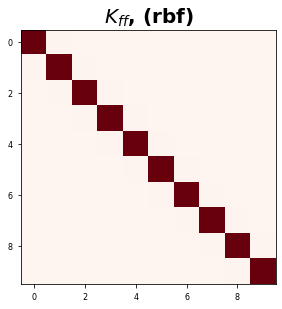

In [45]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X.copy()#[:2, :]
test_Y = X.copy() #[:2, :]

rbf_x_sk = rbf_sklearn(
    onp.array(test_X), 
    onp.array(test_Y), 
    gamma=1.0
)

params = {'gamma': 1.0, 'var_f': 1.0}
rbf_k_ = functools.partial(rbf_kernel, params)
rbf_x = covariance_matrix(
    rbf_k_,
    test_X, 
    test_Y
)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), rbf_x_sk)

plot_kernel_mat(rbf_x)

In [46]:
#@title Tests

kx = rbf_kernel(params, X[0], X[0])

# check, the output should be 1.0
assert kx == 1.0, f"Output: {kx}"

kx = rbf_kernel(params, X[0], X[1])

# check, the output should NOT be 1.0
assert kx != 1.0, f"Output: {kx}"


# dk_dx = drbf_kernel(gamma, X[0], X[0])

# # check, the output should be 0.0
# assert dk_dx == 0.0, f"Output: {dk_dx}"

# dk_dx = drbf_kernel(gamma, X[0], X[1])

# # check, the output should NOT be 0.0
# assert dk_dx != 0.0, f"Output: {dk_dx}"

In [47]:
#@title Speed Test
    
# Covariance Matrix
def covariance_matrix(kernel_func, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

def gram(func, x, y):
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(x))(y)

rbf_K = functools.partial(rbf_kernel, params)
rbf_cov =  jax.jit(functools.partial(covariance_matrix, rbf_K))
rbf_x = rbf_cov(test_X,  test_Y)


rbf_cov2 =  jax.jit(functools.partial(gram, rbf_K))
rbf_x2 = rbf_cov2(test_X,  test_Y)

onp.testing.assert_array_almost_equal(onp.array(rbf_x), onp.array(rbf_x2))

In [48]:
%timeit _ = rbf_cov(test_X,  test_Y)
%timeit _ = rbf_cov2(test_X,  test_Y)

182 µs ± 20.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
167 µs ± 941 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## 1. Cross-Covariance Term - 1st Derivative


We can calculate the cross-covariance term $K_{fg}(\mathbf{x,x})$. We apply the following operation

$$
K_{fg}(x,x') = k_{ff}(\mathbf{x,x'})(1, \frac{\partial}{\partial x'})
$$
If we multiply the terms across, we get:
$$
K_{fg}(x,x') = k_{ff}(\mathbf{x,x'})\frac{\partial k_{ff}(\mathbf{x,x'})}{\partial x'}
$$

For the RBF Kernel, it's this:

$$\frac{\partial k(x,y)}{\partial x^j}=-2 \gamma (x^j - y^j) k(x,y)$$


### Single Sample

In [49]:
X, Y, X_test = get_1d_data(10, sigma_obs=0.1)

test_X = X[0:1, :]
test_Y = X[1:2, :]

#### From Scratch

In [50]:
def drbf_kernel_scratch(gamma, X, Y):
    dK_fg_ = onp.empty(X.shape[-1])
    
    constant = - 2 * gamma
    
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    for idim in range(X.shape[1]):
        
        x_val = X[:, idim] - Y[:, idim]

        dK_fg_[idim] = constant * k_val *  x_val 
    return dK_fg_

In [51]:
dK_fg_ = drbf_kernel_scratch(gamma, test_X, test_Y)
print(dK_fg_)

[0.01392619]


#### Jax

In [52]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

# calculate for a single sample
dK_fg = drbf_kernel_fg(params, test_X[0,:], test_Y[0,:])
print(dK_fg)


[0.01392619]


### Multiple Dimensions

In [53]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X[0:1, :]
test_Y = X[1:2, :]

#### From Scratch

In [54]:
dK_fg_ = drbf_kernel_scratch(gamma, test_X, test_Y)
print(dK_fg_)

[0.0173953  0.00608835]


#### Jax

In [55]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

# calculate for a single sample
dK_fg = drbf_kernel_fg(params, test_X[0,:], test_Y[0,:])
print(dK_fg)

[0.0173953  0.00608835]


### Multiple Samples (Batches)

In [56]:
X, Y, X_test = get_2d_data(10, sigma_obs=0.1)

test_X = X
test_Y = X

#### From Scratch

In [57]:
dK_fg_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        dK_fg_[i, j, :] = drbf_kernel_scratch(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))

#### Jax



In [58]:
# define the cross operator K_fg(x, y), dK wrt x
drbf_kernel_fg = jax.jacobian(rbf_kernel, argnums=(1))

K_func = functools.partial(drbf_kernel_fg, params)
dK_fg = gram(K_func, test_X, test_Y)


onp.testing.assert_array_almost_equal(onp.array(dK_fg), dK_fg_)

## 2. Cross-Covariance Term - 2nd Derivative

$$
\frac{\partial^2 k(x,y)}{\partial x^{j^2}} =
2 \gamma \left[ 2\gamma(x^j - y^j)^2 - 1\right] k(\mathbf{x}, \mathbf{y})
$$

#### From Scratch

In [59]:
def d2rbf_kernel_scratch_jac(gamma, X, Y):
    d2K_fg2_ = onp.empty(X.shape[-1])
    
    constant = 2 * gamma
    
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    for idim in range(X.shape[1]):
        
        x_val = constant * (X[:, idim] - Y[:, idim]) ** 2 - 1

        d2K_fg2_[idim] = constant * k_val *  x_val 
    return d2K_fg2_

In [60]:
d2K_fg2_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        d2K_fg2_[i, j, :] = d2rbf_kernel_scratch_jac(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))

#### Jax

In [61]:
# define the cross operator K_fg(x, y), dK wrt x
dK_fg_func = jax.hessian(rbf_kernel, argnums=(1))

K_func = functools.partial(dK_fg_func, params)
d2K_fg2 = covariance_matrix(K_func, test_X, test_Y)

d2K_fg2 = jnp.diagonal(d2K_fg2, axis1=2, axis2=3)

d2K_fg2.shape

(10, 10, 2)

In [62]:
onp.testing.assert_array_almost_equal(onp.array(d2K_fg2), d2K_fg2_)

## 3. Cross-Covariance Term - 2nd Derivative (Partial Derivatives)

$$
\frac{\partial^2 k(x,y)}{\partial x^j \partial y^k} =
4 \gamma^2 (x^k - y^k)(x^j - y^j) k(\mathbf{x}, \mathbf{y})
$$

#### From Scratch

In [63]:
def d2rbf_kernel_scratch_hessian(gamma, X, Y):
    d2K_fg2_ = onp.empty((X.shape[-1], X.shape[-1]))
    
    constant = 2 * gamma
    constant_sq = constant ** 2
    
    k_val = rbf_sklearn(onp.array(X), onp.array(Y), gamma=gamma)
    
    for idim in range(X.shape[1]):
        for jdim in range(X.shape[1]):
        
            x_val = constant * (1 - constant * (X[:, idim] - Y[:, idim]) * (X[:, jdim] - Y[:, jdim]))# - constant

            d2K_fg2_[idim, jdim] = k_val *  x_val 
    return d2K_fg2_

In [64]:
d2K_fg2_ = onp.empty((test_X.shape[0], test_X.shape[0], test_X.shape[1], test_X.shape[1]))

for i in range(test_X.shape[0]):
    for j in range(test_Y.shape[0]):
        
        d2K_fg2_[i, j, ...] = d2rbf_kernel_scratch_hessian(gamma, onp.array(test_X[i, :]).reshape(1,-1), onp.array(test_Y[j, :]).reshape(1, -1))

#### Jax

In [65]:
# define the cross operator K_fg(x, y), dK wrt x
dK_fg_func = jax.hessian(rbf_kernel, argnums=(1))

K_func = functools.partial(dK_fg_func, params)
d2K_fg2 = covariance_matrix(K_func, test_X, test_Y)

d2K_fg2.shape

(10, 10, 2, 2)

In [66]:
onp.testing.assert_array_almost_equal(onp.array(onp.diagonal(d2K_fg2, axis1=2, axis2=3 )), jnp.diagonal(d2K_fg2, axis1=2, axis2=3))

In [67]:
onp.testing.assert_array_almost_equal(onp.array(d2K_fg2), d2K_fg2_)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 112 / 400 (28%)
Max absolute difference: 4.
Max relative difference: 2.40703559
 x: array([[[[-2.000000e+00,  0.000000e+00],
         [ 0.000000e+00, -2.000000e+00]],
...
 y: array([[[[ 2.000000e+00,  2.000000e+00],
         [ 2.000000e+00,  2.000000e+00]],
...